#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Нужно:**
- Провести анализ данных
- Построить модель для предсказания количества заказов такси на следующий час.

**Требования:**  
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**О данных:**  
Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` 

## Подготовка

### Импорт

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# выборки
from sklearn.model_selection import train_test_split, TimeSeriesSplit
# модели
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
# optuna
import optuna
from optuna_integration import OptunaSearchCV
from optuna.distributions import (
    IntDistribution,
    CategoricalDistribution,
    FloatDistribution
)
# metrics
from sklearn.metrics import mean_squared_error

In [71]:
# константы
RANDOM_STATE = 0
RMSE_GOAL = 48

In [72]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

### Загрузка данных

In [145]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Ресемплирование
ресемпоирование данных по часу.

In [76]:
df = df.resample('1H').sum()
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Очевилные пропуски в данных отсутствуют. теперь проверю индекс на монотонность.

In [80]:
df.index.is_monotonic_decreasing or df.index.is_monotonic_increasing

True

Описание значений целевого признака

In [82]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Среднее значение 84, со стандартным отклонением 45, медиана 78, минимальное значение 0 а максимальное 462.

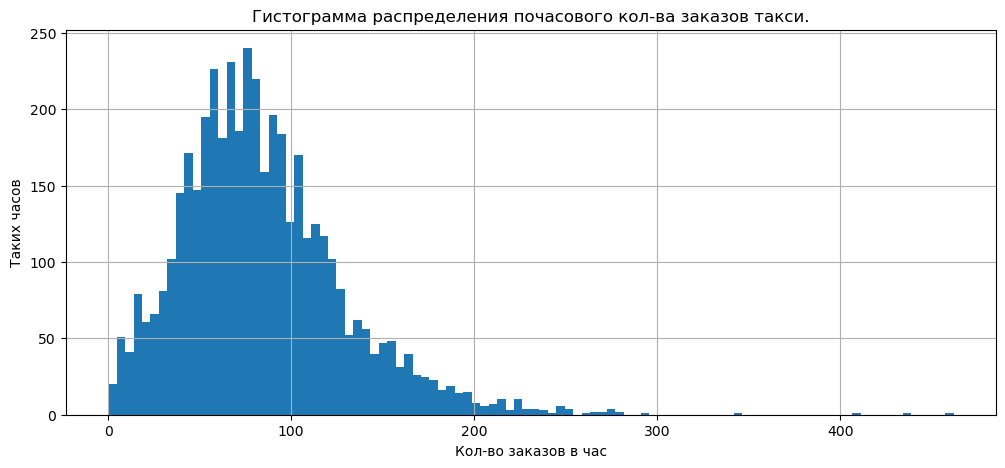

In [84]:
df['num_orders'].hist(bins=100, figsize = (12,5))
plt.title(f'Гистограмма распределения почасового кол-ва заказов такси.')
plt.xlabel('Кол-во заказов в час')
plt.ylabel('Таких часов');

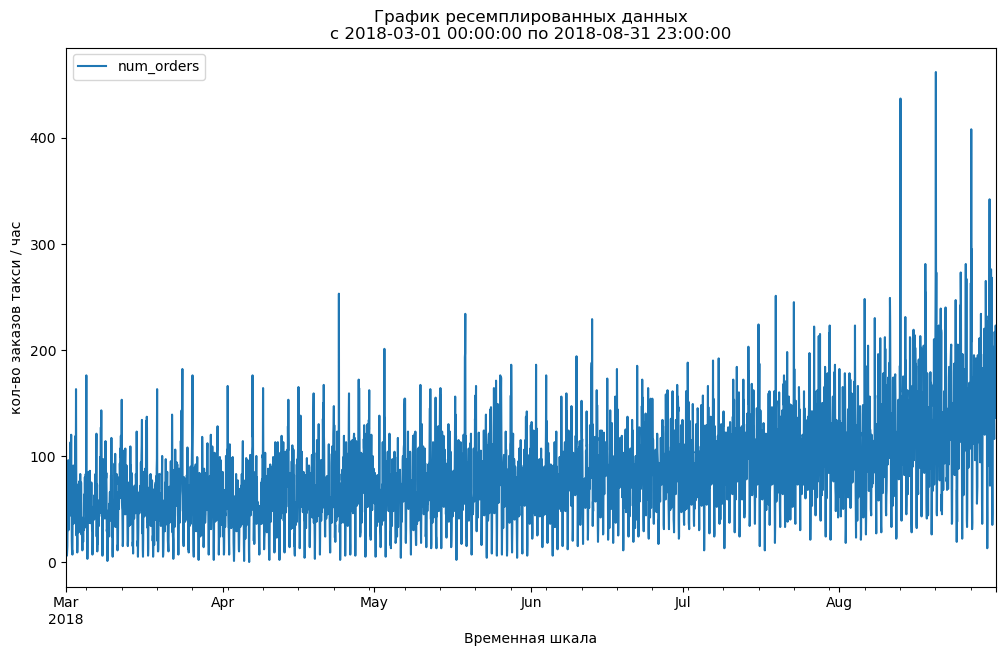

In [85]:
df.plot(figsize = (12,7))
plt.title(f'График ресемплированных данных\nс {df.index.min()} по {df.index.max()}')
plt.xlabel('Временная шкала')
plt.ylabel('кол-во заказов такси / час');

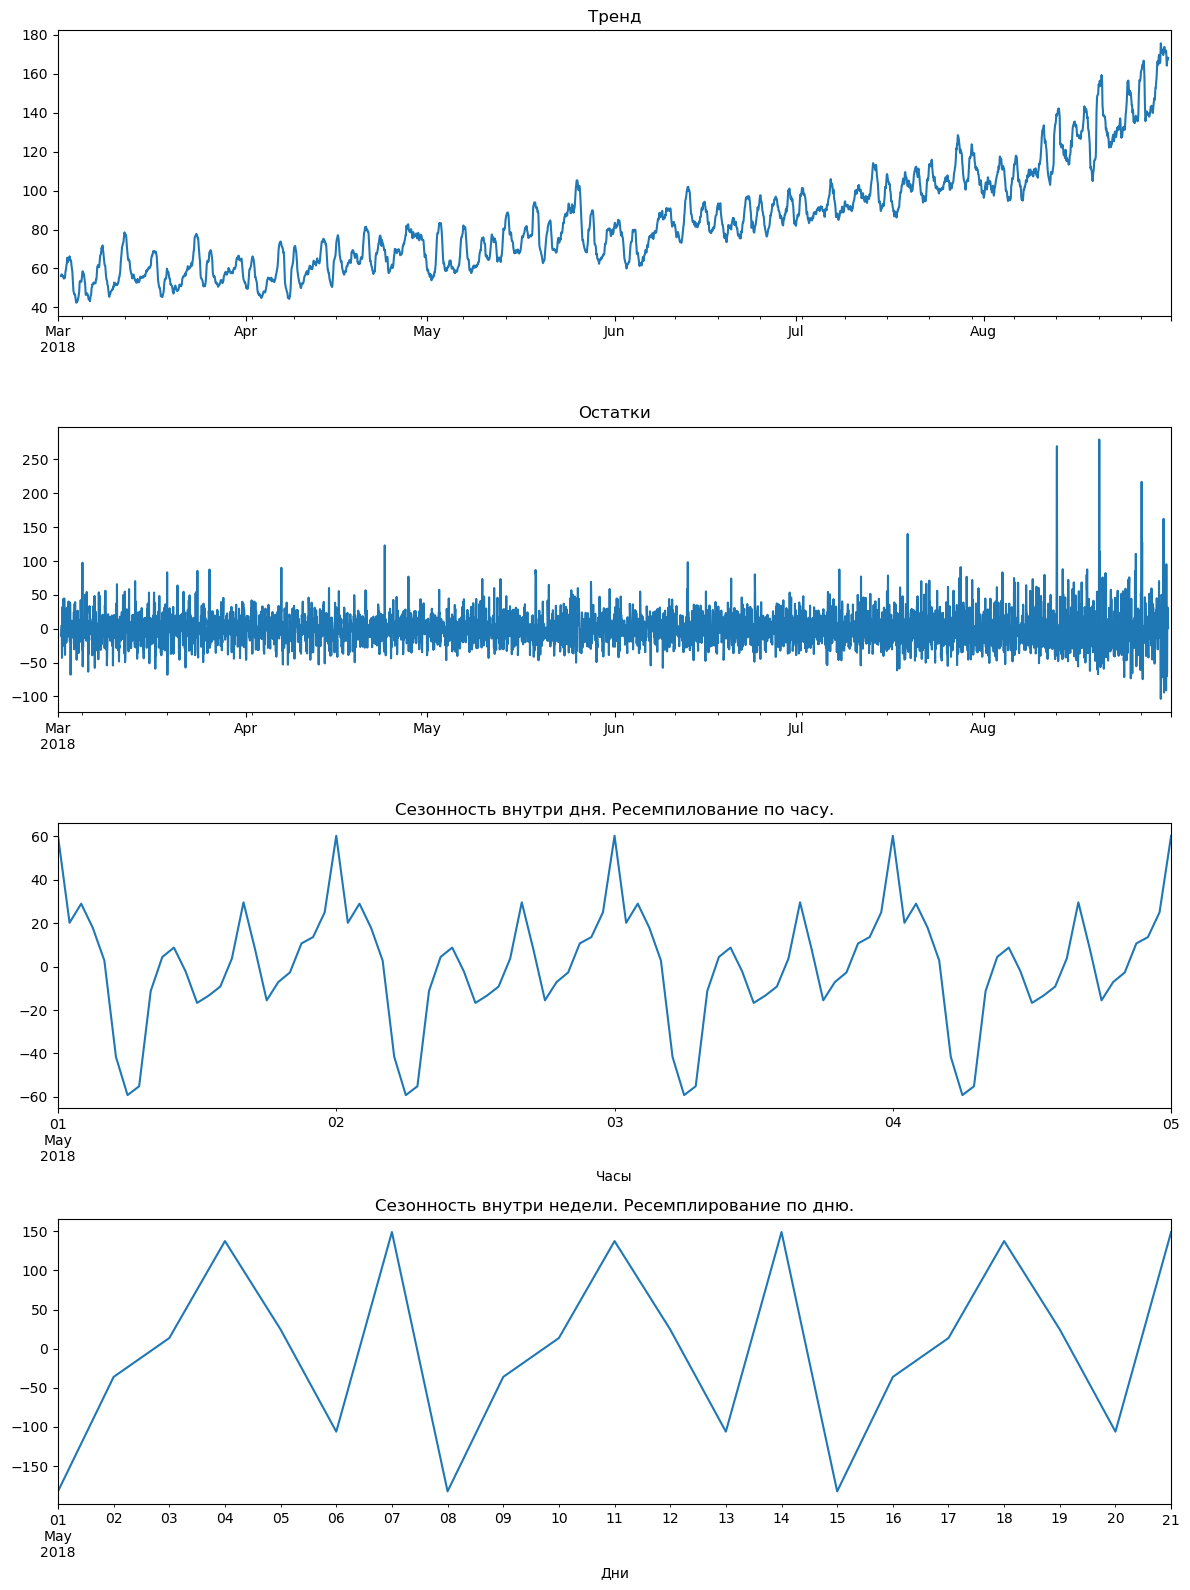

In [86]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 16))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('')
plt.subplot(412)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остатки')
plt.xlabel('')
plt.subplot(413)
decomposed.seasonal['2018-05-01 00:00:00':'2018-05-05 00:00:00'].plot(ax=plt.gca()) 
plt.title('Сезонность внутри дня. Ресемпилование по часу.')
plt.xlabel('Часы')
plt.subplot(414)
decomposed = seasonal_decompose(df.resample('1D').sum())
decomposed.seasonal['2018-05-01 00:00:00':'2018-05-21 00:00:00'].plot(ax=plt.gca())
plt.title('Сезонность внутри недели. Ресемплирование по дню.')
plt.xlabel('Дни')
plt.tight_layout();



In [87]:
# использую функцию-пример из документации statsmodels для определения стационарности 
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
adf_test(df)

Results of Dickey-Fuller Test:
Test Statistic                   -3.068924
p-value                           0.028940
#Lags Used                       30.000000
Number of Observations Used    4385.000000
Critical Value (1%)              -3.431842
Critical Value (5%)              -2.862199
Critical Value (10%)             -2.567121
dtype: float64


p-value больше критического значения, временной ряд нестационарен

## Обучение

### Создание признаков

In [91]:
def feature_creation(data, target, lags, rolling):
    new_data = data
    new_data['hour'] = data.index.hour
    new_data['day_of_weak'] = data.index.dayofweek
    for lag in lags:
        new_data[f'lag_{lag}'] = data[target].shift(lag)
    new_data['rolling_mean'] = data[target].shift(24).rolling(rolling).mean()
    new_data = new_data.dropna()
    return new_data

In [92]:
data = feature_creation(df, 'num_orders', [24, 7*24], 24)

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4248 non-null   int64  
 1   hour          4248 non-null   int64  
 2   day_of_weak   4248 non-null   int64  
 3   lag_24        4248 non-null   float64
 4   lag_168       4248 non-null   float64
 5   rolling_mean  4248 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 232.3 KB


### Создание выборок

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('num_orders', axis=1),
    data['num_orders'],
    shuffle=False,
    test_size = 0.1
)
print(f'Shapes: \nX_train{X_train.shape}, y_train{y_train.shape} \nX_test{X_test.shape}, y_test{y_test.shape}')

Shapes: 
X_train(3823, 5), y_train(3823,) 
X_test(425, 5), y_test(425,)


### Обучение моделей

In [97]:
ridge_params = {
    'alpha': FloatDistribution(0, 10**5),
    'solver': CategoricalDistribution(['auto', 'svd', 'cholesky',  'saga'])
}
tree_params = {
    'max_depth': IntDistribution(5,20),
    'min_samples_leaf': IntDistribution(1,10),
    'max_features': IntDistribution(1,10),
}
neighbors_params ={
    'n_neighbors': IntDistribution(1,10),
    'metric': CategoricalDistribution(['cityblock', 'euclidean', 'manhattan', 'minkowski'])
}


In [98]:
tscv = TimeSeriesSplit(n_splits=3)

####  Линейная регрессия

In [100]:
ridge = OptunaSearchCV(
    Ridge(random_state=RANDOM_STATE),
    ridge_params,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_trials=20
)

C:\Users\user\AppData\Local\Temp\ipykernel_32124\2259021529.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  ridge = OptunaSearchCV(


In [101]:
ridge.fit(X_train, y_train)

OptunaSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
               estimator=Ridge(random_state=0), n_jobs=-1, n_trials=20,
               param_distributions={'alpha': FloatDistribution(high=100000.0, log=False, low=0.0, step=None),
                                    'solver': CategoricalDistribution(choices=('auto', 'svd', 'cholesky', 'saga'))},
               random_state=0, scoring='neg_root_mean_squared_error')

#### Дерево

In [103]:
tree = OptunaSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    tree_params,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_trials=20
)

C:\Users\user\AppData\Local\Temp\ipykernel_32124\2434750115.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  tree = OptunaSearchCV(


In [104]:
tree.fit(X_train, y_train)

OptunaSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
               estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
               n_trials=20,
               param_distributions={'max_depth': IntDistribution(high=20, log=False, low=5, step=1),
                                    'max_features': IntDistribution(high=10, log=False, low=1, step=1),
                                    'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)},
               random_state=0, scoring='neg_root_mean_squared_error')

#### Ближайшие соседи

In [106]:
neighbors = OptunaSearchCV(
    KNeighborsRegressor(),
    neighbors_params,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_trials=20
)

C:\Users\user\AppData\Local\Temp\ipykernel_32124\311224092.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  neighbors = OptunaSearchCV(


In [107]:
neighbors.fit(X_train, y_train)

OptunaSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
               estimator=KNeighborsRegressor(), n_jobs=-1, n_trials=20,
               param_distributions={'metric': CategoricalDistribution(choices=('cityblock', 'euclidean', 'manhattan', 'minkowski')),
                                    'n_neighbors': IntDistribution(high=10, log=False, low=1, step=1)},
               random_state=0, scoring='neg_root_mean_squared_error')

## Тестирование

In [109]:
best_rmse = -RMSE_GOAL
best_model = ''
for model in [ridge, tree, neighbors]:
    if model.best_score_ >= best_rmse:
        best_rmse = model.best_score_
        best_model = model
    print(f'RMSE for {model.estimator}: {abs(model.best_score_):.3f}')
    
print(f'\nBest model: {best_model.estimator} with RMSE:{-best_rmse:.3f}')

RMSE for Ridge(random_state=0): 24.828
RMSE for DecisionTreeRegressor(random_state=0): 27.163
RMSE for KNeighborsRegressor(): 26.341

Best model: Ridge(random_state=0) with RMSE:24.828


Данная модель показала лучшие результаты и будет использованна для проверки на тестовых данных

### RMSE на тестовых данных

In [112]:
rmse = mean_squared_error(y_test, best_model.best_estimator_.predict(X_test), squared=False)
print(f'RMSE на тестовых данных: {rmse:.3f}, что  {"удовлетворяет" if rmse<RMSE_GOAL else "не удовлетворяет"} условию. ') 

RMSE на тестовых данных: 36.715, что  удовлетворяет условию. 


Лучшая модель удовлетворяет условиям метрики.

### Сравнение с подстановкой предыдущего значения

In [115]:

dummy_rmse = mean_squared_error(y_test, y_test.shift(-1, fill_value=0), squared=False)
print(f'Dummy RMSE: {dummy_rmse:.3f}')

Dummy RMSE: 59.653


Лучшая модель предсказывает лучше константного предсказателя.

## Обший вывод
В ходе изучения исторических данных заказах такси в аэропортах **были обнаружены сезонные закономерности**:
- Внутри дня
- Внутри недели  
На их основе, а также на основе самого временного ряда **были созданны признаки** которые помогли обучить несколько моделей машинного обучения.  
  
Задача данных моделей состояла в прогнозировании кол-ва заказов. **Были обучены модели**: 
- Линейной регресссии c L2 регуляризацией
- Регрессия на основе решающего дерева
- Регрессия методом ближайших соседей  
  
Среди обученных моделей была выбрана лучшая и проверена на тестовых данных. **Лучшей моделью по метрике RMSE оказалась модель линейной регрессии с L2 регуляризацией**. Модель удовлетворяет значениям метрики и превосходит прогнозирование по подстановке предыдущего значения. 
